<a href="https://colab.research.google.com/github/dung18520632/NhanDien_CS338.L21/blob/main/Optimize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
%cd /content/drive/MyDrive/darknet

/content/drive/MyDrive/darknet


In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile


In [4]:
!make

make: *** No targets specified and no makefile found.  Stop.


In [6]:
def load_network_1(config_file, data_file, weights, batch_size=1):
    """
    load model description and weights from config files
    args:
        config_file (str): path to .cfg model file
        data_file (str): path to .data model file
        weights (str): path to weights
    returns:
        network: trained model
        class_names
        class_colors
    """
    network = load_net_custom(
        config_file.encode("ascii"),
        weights.encode("ascii"), 0, batch_size)
    metadata = load_meta(data_file.encode("ascii"))
    class_names = [metadata.names[i].decode("ascii") for i in range(1)]
    colors = class_colors(class_names)
    return network, class_names, colors

In [7]:
from darknet import *
#608X608
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network_1("cfg/yolov4.cfg", "cfg/coco.data", "yolov4.weights")
width = network_width(network)
height = network_height(network)

In [8]:
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

In [9]:
def Detection(detections,image):
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  cv2_imshow(image)

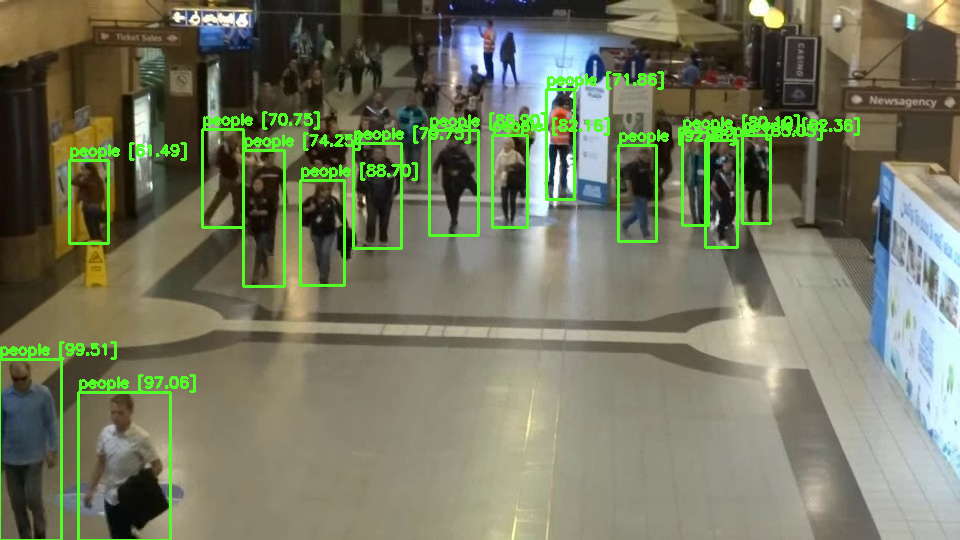

In [45]:
image = cv2.imread("/content/MOT20_02_raw_frame_100.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)
boxes = [bbox for _,_,bbox in detections]
Detection(detections,image)

In [37]:
original_image_BGR = cv2.imread('/content/MOT20_02_raw_frame_100.jpg')
original_image_RGB = cv2.cvtColor(original_image_BGR, cv2.COLOR_BGR2RGB)
image_width = original_image_RGB.shape[1]
image_height = original_image_RGB.shape[0]

original_image_BGR_copy = original_image_BGR.copy()
original_image_RGB_copy = original_image_RGB.copy()

print('image Shape', original_image_RGB.shape)

image Shape (540, 960, 3)


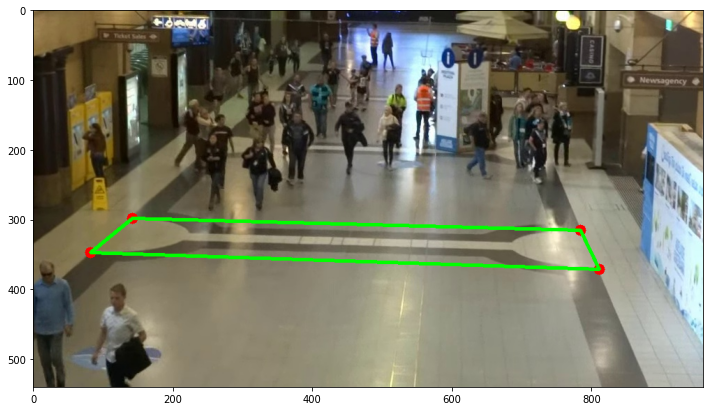

The perspective transform matrix:
[[ 4.64100594e+00  8.20914118e+00 -2.16714663e+03]
 [ 8.94136789e-02  2.14071423e+01 -1.19908691e+03]
 [ 3.12807115e-04  1.61722589e-02  1.00000000e+00]]


In [38]:
src = np.float32([[142., 298.],
                           [784., 315.],
                           [811., 371.],
                           [ 82., 347.]])
for point in src:
    cv2.circle(original_image_RGB_copy, tuple(point), 8, (255, 0, 0), -1)

points = src.reshape((-1,1,2)).astype(np.int32)
cv2.polylines(original_image_RGB_copy, [points], True, (0,255,0), thickness=4)
plt.figure(figsize=(12, 12))
plt.imshow(original_image_RGB_copy)
plt.show()
dst=np.float32([(0.2,0.82), (0.80, 0.82), (0.80,0.87), (0.2,0.87)])

dst_size=(800,1080)
dst = dst * np.float32(dst_size)

H_matrix = cv2.getPerspectiveTransform(src, dst)
print("The perspective transform matrix:")
print(H_matrix)

In [39]:
pts= np.float32([[[252., 314.],
                 [323., 316.],
                 [238., 347.]]])
# dst = np.array([[252,314],[323,316],[238,347]],np.float32)
warped_pt=cv2.perspectiveTransform(pts,H_matrix)[0]

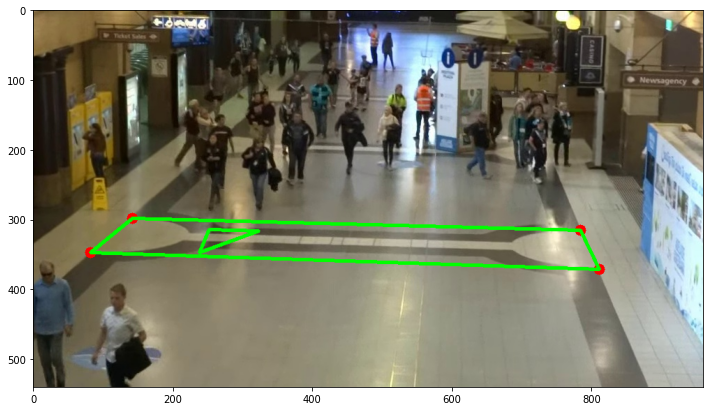

In [40]:
points = pts.reshape((-1,1,2)).astype(np.int32)
cv2.polylines(original_image_RGB_copy, [points], True, (0,255,0), thickness=4)

plt.figure(figsize=(12, 12))
plt.imshow(original_image_RGB_copy)
plt.show()

In [41]:
distance_w = np.sqrt((warped_pt[0][0] - warped_pt[1][0]) ** 2 + (warped_pt[0][1] - warped_pt[1][1]) ** 2)
distance_h = np.sqrt((warped_pt[0][0] - warped_pt[2][0]) ** 2 + (warped_pt[0][1] - warped_pt[2][1]) ** 2)

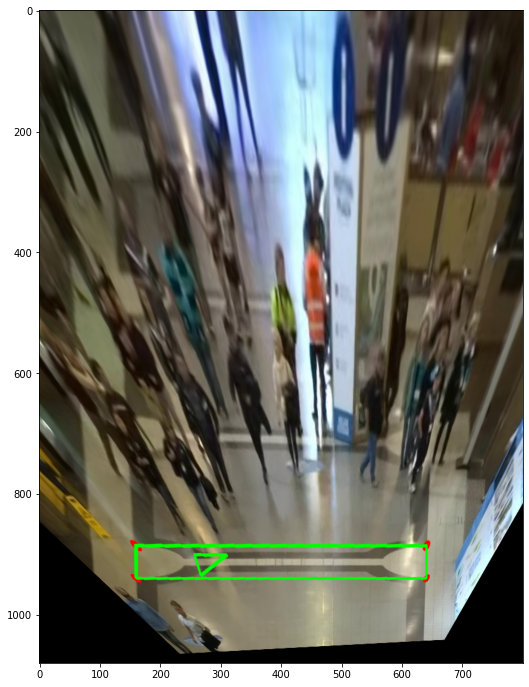

In [42]:
warped = cv2.warpPerspective(original_image_RGB_copy, H_matrix, dst_size)

plt.figure(figsize=(12, 12))
plt.imshow(warped)
plt.show()

In [43]:
print(boxes)

[(351.37908935546875, 138.96261596679688, 18.661447525024414, 83.34181213378906), (317.56988525390625, 101.66542053222656, 10.038162231445312, 74.29376983642578), (263.534423828125, 199.08831787109375, 19.7869873046875, 89.61882019042969), (241.07325744628906, 200.8717041015625, 22.20563316345215, 98.86823272705078), (278.60626220703125, 233.8659210205078, 23.93198585510254, 120.51268768310547), (291.2264709472656, 220.2126007080078, 19.05910301208496, 111.00003814697266), (194.2058868408203, 189.52322387695312, 18.758665084838867, 88.20389556884766), (22.564931869506836, 559.755615234375, 44.621055603027344, 98.5997543334961), (468.7789306640625, 278.1861877441406, 37.69599533081055, 125.81019592285156), (73.07400512695312, 419.362060546875, 41.967472076416016, 97.73238372802734), (503.12420654296875, 243.68797302246094, 22.62335968017578, 113.64476013183594), (358.60443115234375, 205.83395385742188, 20.269317626953125, 119.38685607910156), (132.01417541503906, 508.5785217285156, 35.8

In [60]:
def Point_transform(H_matrix,boxes):
      list_downoids = [[bbox[0],bbox[1]+bbox[3]//2] for bbox in boxes]
      list_points_to_detect=np.float32(list_downoids).reshape(-1,1,2)
      transformed_point=cv2.perspectiveTransform(list_points_to_detect,H_matrix)
      transformed_point_list= list()
      for i in range (0,transformed_point.shape[0]):
        transformed_point_list.append([transformed_point[i][0][0],transformed_point[i][0][1]])
      return np.array(transformed_point_list).astype('int')
birds_eye_points=Point_transform(H_matrix,boxes)


In [20]:
birds_eye_points

array([[  62,  856],
       [ 406,  810],
       [ 112,  827],
       [ 278,  766],
       [ 200,  912],
       [ 220,  858],
       [ 374,  814],
       [ 272,  820],
       [ 396,  850],
       [ 248,  835],
       [ 226,  910],
       [ 351,  843],
       [ 293, 1088],
       [ 269, 1090]])

In [21]:
def eucledian_distance_1(point1, point2,distance_w, distance_h):
    x1,y1 = point1
    x2,y2 = point2
    h=abs(y2-y1)
    w=abs(x2-x1)
    dis_w = float((w/distance_w)*180)
    dis_h = float((h/distance_h)*180)
    
    return int(np.sqrt(((dis_h)**2) + ((dis_w)**2)))

In [62]:
def get_red_green_boxes_1(distance_allowed,Point_transform,boxes):
    red_boxes = []
    green_boxes = []
    new_boxes = [tuple(box) + tuple(result) for box, result in zip(boxes, birds_eye_points)]
    for i in range(0, len(new_boxes)-1):
            for j in range(i+1, len(new_boxes)):
                cxi,cyi = new_boxes[i][4:]
                cxj,cyj = new_boxes[j][4:]
                distance = eucledian_distance_1([cxi,cyi], [cxj,cyj],distance_w, distance_h)
                if distance < distance_allowed:
                    red_boxes.append(new_boxes[i])
                    red_boxes.append(new_boxes[j])
    print(len(red_boxes))
    green_boxes = list(set(new_boxes) - set(red_boxes))
    red_boxes = list(set(red_boxes))

    return (green_boxes, red_boxes)

In [23]:
min_distance = 120
green_box,red_box=get_red_green_boxes(min_distance, birds_eye_points, boxes)

8


In [24]:
def convertBack(x, y, w, h): 
    #================================================================
    # 2.Purpose : Converts center coordinates to rectangle coordinates
    #================================================================  
    """
    :param:
    x, y = midpoint of bbox
    w, h = width, height of the bbox
    
    :return:
    xmin, ymin, xmax, ymax
    """
    xmin = int(round(x - (w / 2)))
    xmax = int(round(x + (w / 2)))
    ymin = int(round(y - (h / 2)))
    ymax = int(round(y + (h / 2)))
    return xmin, ymin, xmax, ymax

In [56]:
def get_red_green_box_image(new_box_image,green_box,red_box,width_ratio,height_ratio):
    for point in green_box:
        xmin, ymin, xmax, ymax = convertBack(point[0], point[1], point[2],point[3])
        xmin, ymin, xmax, ymax = int(xmin * width_ratio), int(ymin * height_ratio), int(xmax * width_ratio), int(ymax * height_ratio)
        cv2.rectangle(new_box_image,(xmin,ymin),(xmax,ymax),(0, 255, 0), 2)
    for point in red_box:
        xmin, ymin, xmax, ymax = convertBack(point[0], point[1], point[2],point[3])
        xmin, ymin, xmax, ymax = int(xmin * width_ratio), int(ymin * height_ratio), int(xmax * width_ratio), int(ymax * height_ratio)
        cv2.rectangle(new_box_image,(xmin,ymin),(xmax,ymax),(0, 0, 255), 2)
    return new_box_image

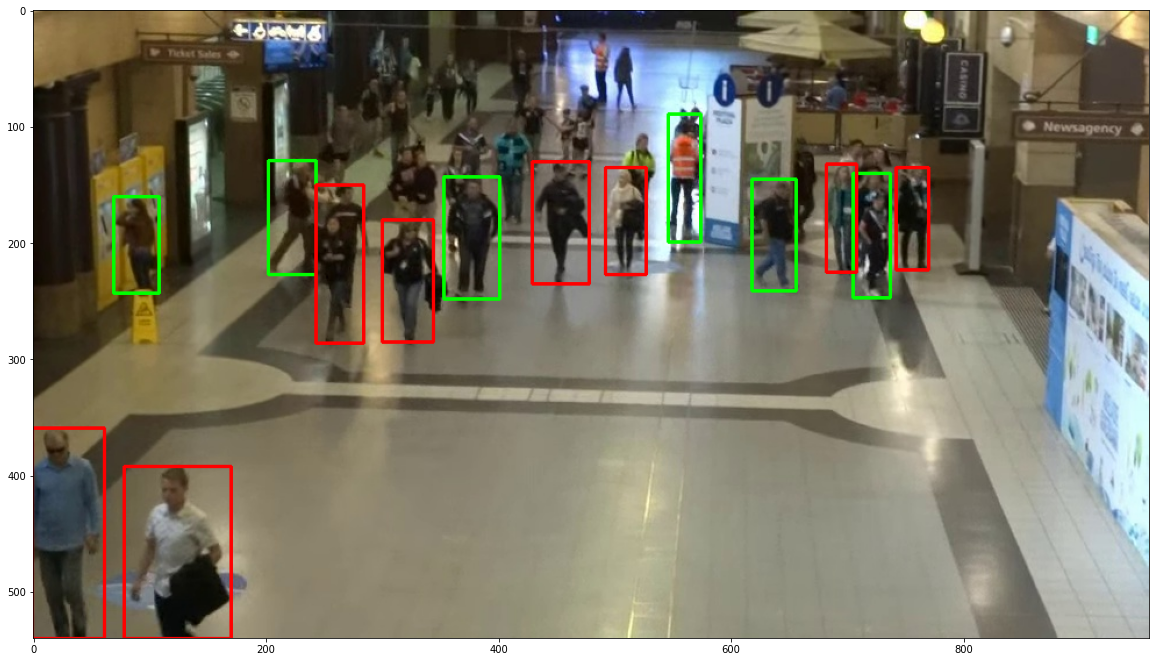

In [57]:
box_red_green_image = get_red_green_box_image(original_image_BGR.copy(),green_box,red_box,width_ratio,height_ratio)
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(box_red_green_image, cv2.COLOR_RGB2BGR))
plt.show()

In [50]:
def get_birds_eye_view_image(green_box, red_box,eye_view_height,eye_view_width):
    blank_image = cv2.imread('/content/black_background.png')
    
    cv2.putText(blank_image, str(len(red_box)), (120,100), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,0,255), 4, cv2.LINE_AA) 
    cv2.putText(blank_image, str(len(green_box)), (520,100), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,255,0), 4, cv2.LINE_AA)
    
    for point in green_box:
        cv2.circle(blank_image,tuple([point[4],point[5]]),20,(0,255,0),-1)
    for point in red_box:
        cv2.circle(blank_image,tuple([point[4],point[5]]),20,(0,0,255),-1)
    blank_image = cv2.resize(blank_image,(eye_view_width,eye_view_height))
    return blank_image

In [51]:
birds_eye_view_image = get_birds_eye_view_image(green_box, red_box,eye_view_height=image_height,eye_view_width=image_width//2)

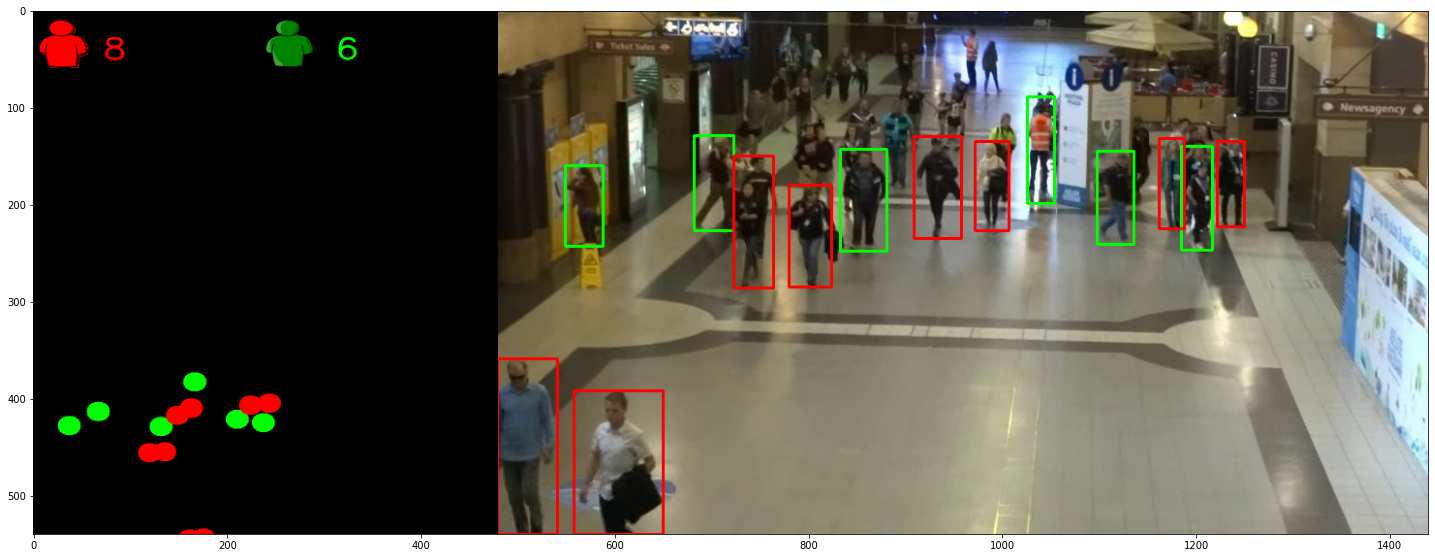

In [54]:
combined_image = np.concatenate((birds_eye_view_image,box_red_green_image), axis=1)
plt.figure(figsize=(25, 20))
plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_RGB2BGR))
plt.show()

In [67]:
import sys
video = cv2.VideoCapture('/content/People2.mp4')
writer = None
frame_number = 0
print('%-20s%-26s%-26s%-26s' % ('Processing Frame','|Total Detected Person','|Red Markerd Person','|Green Marked Person'))
while True:
  
  ret,frame = video.read()

  if not ret:
    break
  detections, width_ratio, height_ratio = darknet_helper(frame, width, height)
  boxes = [bbox for _,_,bbox in detections]
  birds_eye_points = Point_transform(H_matrix, boxes)
  green_box, red_box = get_red_green_boxes_1(min_distance, birds_eye_points,boxes)
  birds_eye_view_image = get_birds_eye_view_image(green_box, red_box, eye_view_height=image_height,eye_view_width=image_width//2)
  box_red_green_image = get_red_green_box_image(frame.copy(), green_box,red_box,width_ratio,height_ratio)

  combined_image = np.concatenate((birds_eye_view_image,box_red_green_image), axis=1)

  frame_number += 1
  sys.stdout.write('%-20i|%-25i|%-25i|%-25i\n' % (frame_number,len(boxes),len(red_box),len(green_box)))

  # if frame_number >=20:
  #   break

  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"DIVX")
    writer = cv2.VideoWriter('/content/test.avi', fourcc, 15, (combined_image.shape[1], combined_image.shape[0]), True)

  writer.write(combined_image)

  del detections,combined_image,birds_eye_view_image

print(' ')
writer.release()
video.release()

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
283                 |16                       |9                        |7                        
12
284                 |16                       |10                       |6                        
8
285                 |17                       |7                        |10                       
10
286                 |17                       |8                        |9                        
14
287                 |18                       |12                       |6                        
14
288                 |18                       |12                       |6                        
10
289                 |16                       |8                        |8                        
8
290                 |17                       |7                        |10                       
10
291                 |18                       |8                        |10                       
12
292                 |20    